torch.Size([4096])
torch.Size([64, 4096])


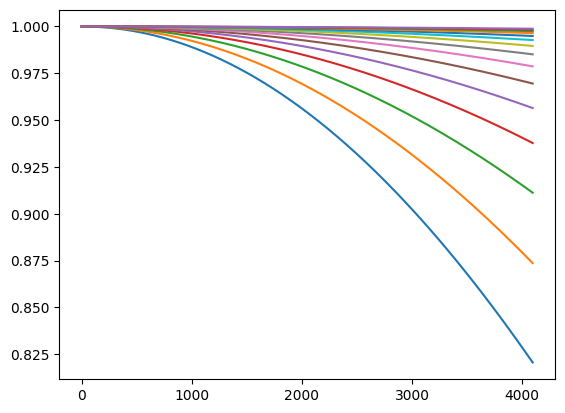

In [4]:
import torch
from matplotlib import pyplot as plt
%matplotlib inline

ratio = 100000
dim = 128
l = 4096
# 1/(ratio)^(2i/d)
# Calculate the cosine and sine rotation values from RoPE
def cossin(ratio, dim, l):
    freqs_ = 1.0 / (
        ratio
        ** (torch.arange(0, dim, 2)[: (dim//2)].float() / (dim-0))
    )
    t = torch.arange(l)
    print(t.shape)
    freqs = torch.outer(freqs_, t).float()
    cos = freqs.cos()
    sin = freqs.sin()
    return cos, sin, freqs_

cos,sin,f = cossin(ratio, dim, l)
print(cos.shape)

# Plot the periods of the 16 lowest frequencies
plt.figure()
for i,seq in enumerate(cos):
    if i>dim//2-16:
        plt.plot(seq)
# plt.savefig('./rope_cos_500k.png', dpi=200, bbox_inches="tight")
plt.show()

torch.Size([131072])


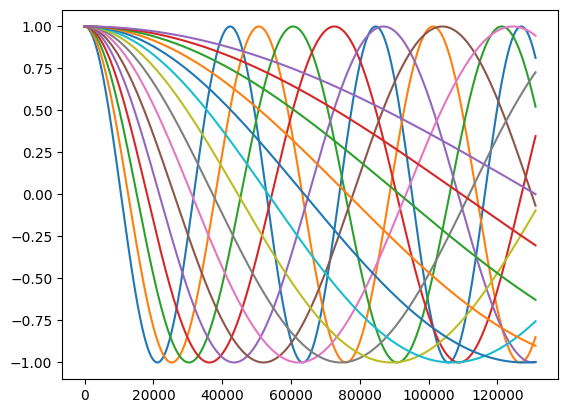

In [5]:
# The same plot, but over a longer sequence length. All those periods have completed.

cos,sin,f = cossin(ratio, dim, l*32)

plt.figure()
for i,seq in enumerate(cos):
    if i>dim//2-16:
        plt.plot(seq)
plt.show()

torch.Size([4096])
4096
tensor([       nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,        nan,
        2.5577e-05, 5.1648e-05, 5.4463e-05, 1.0266e-04, 1.4995e-04, 1.5405e-04,
        1.7966e-04, 2.3567e-04, 2.5891e-04, 2.6720e-04, 2.9526e-04, 3.3066e-04,
        3.6408e-04, 3.9164e-04, 3.9341e-04, 4.1261e-04, 4.2832e-04, 5.0560e-04,
        5.3063e-04, 5.4605e-04, 5.5247e-04, 5.7156e-04, 5.8436e-04, 6.3826e-04,
        6.5603e-04, 6.5909e-04, 6.7168e-04, 6.8578e-04, 7.4737e-04, 1.5728e-03,
        1.2967e-02, 9.1580e-02, 3.5727e-01, 5.6358e-01, 5.9749e-01, 6.2904e-01,
        6.3252e-01, 6.3975e-01, 6.7611e-01, 6.8348e-01, 6.8793e-01, 6.9029e-01,
        6.9033e-

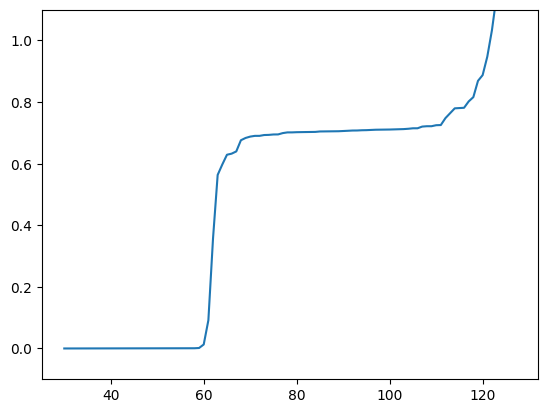

In [6]:
# Apply rotations to an arbitrary starting point of [1,0,1,0,1,0,...] and calculate singular values.
# Zeros indicate the presence of a null space within which RoPE does NOT affect location (and within which meaningful clusters can form).
# Notice how this region shrinks as L grows.
# In the limit, the singular values form a flat line (uncorrelated points mapping the surface of a hypersphere).
# When this happens, clusters cannot form (unless the network learns to explicitly perform anti-RoPE rotation beforehand).

L = 4096
cos,sin,_ = cossin(ratio, dim, L)

cloud = torch.cat([cos, sin], dim=0)
print(len(cos[0]))
print(torch.linalg.eigh(cloud.matmul(cloud.t()).div(len(cos[0])))[0].sqrt())
print(cloud.shape)
plt.figure()
plt.plot(torch.linalg.eigh(cloud.matmul(cloud.t()).div(len(cos[0])))[0].sqrt())
plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 替换为你的数据
# [0.00016785581829026341, 8_group]
# 0: [6, 9, 11, 12, 17, 21], 1: [24, 25, 27], 2: [0, 8, 16, 20, 22, 26, 28, 29], 3: [3, 19, 23, 30], 4: [4, 7], 5: [10, 13], 6: [2, 14, 15], 7: [1, 5, 18, 31]
# [32,32,32,32,32,32,32,32]

# model.layers.1.self_attn.k_proj': {0: [21], 1: [1, 11, 15, 24, 28, 30], 2: [2, 16, 27], 3: [4, 5, 7, 8, 9, 12, 13, 14, 20, 29, 31], 4: [0, 6, 10, 18, 19, 22, 25], 5: [23, 26], 6: [3], 7: [17]
# model.layers.1.self_attn.k_proj': [64, 64, 64, 64, 64, 64, 64, 64]
# 0.010131396353244781
# ppl 6.07

# model.layers.1.self_attn.k_proj': {0: [0, 1, 2, 3], 1: [4, 5, 6, 7], 2: [8, 9, 10, 11], 3: [12, 13, 14, 15], 4: [16, 17, 18, 19], 5: [20, 21, 22, 23], 6: [24, 25, 26, 27], 7: [28, 29, 30, 31]}
# model.layers.1.self_attn.k_proj': [64, 64, 64, 64, 64, 64, 64, 64]
# 0.008319597691297531
# uniform_sim = [0:0.00011929372703889385, 1:0.007752801291644573, 10: 0.06813237071037292]
# 0: 0: [2, 15, 14, 25], 1: [21, 6, 17, 12], 2: [13, 27, 7, 29], 3: [1, 23, 31, 20], 4: [5, 30, 3, 4], 5: [18, 16, 9, 28], 6: [22, 8, 26, 19], 7: [11, 0, 10, 24]
# 1: 0: [2, 30, 11, 24], 1: [20, 14, 29, 12], 2: [13, 8, 7, 27], 3: [1, 18, 15, 22], 4: [5, 31, 9, 3], 5: [19, 0, 25, 28], 6: [21, 6, 17, 23], 7: [16, 10, 4, 26]
# 10: 0: [2, 5, 21, 25], 1: [20, 30, 12, 13], 2: [14, 11, 4, 28], 3: [1, 27, 19, 22], 4: [7, 6, 31, 3], 5: [17, 10, 24, 29], 6: [18, 23, 0, 16], 7: [15, 9, 8, 26]. [160, 160, 160, 160, 160, 160, 160, 160]

# non-uniform 4 group [0: 4.079969949088991e-05, 1: 0.0037290952168405056, 10: 0.05913722515106201] [64, 64, 64, 64] [128, 128, 128, 128] [352, 352, 352, 128]
# 0: 0: [0, 8, 12, 16, 17, 20, 21, 22, 26, 28, 29], 1: [4, 7, 13, 14, 24, 25, 27], 2: [1, 3, 5, 6, 9, 11, 18, 23, 30, 31], 3: [2, 10, 15, 19]
# 1: 0: [21], 1: [1, 2, 11, 15, 16, 24, 27, 28, 30], 2: [0, 3, 6, 10, 17, 18, 19, 22, 23, 25, 26], 3: [4, 5, 7, 8, 9, 12, 13, 14, 20, 29, 31]
# 10: 0: [0, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 24, 28, 30, 31], 1: [14, 22, 25, 26, 29], 2: [1, 5, 8, 16, 27], 3: [23]
# uniform sim [0: 3.4925233194371685e-05, 1: 0.0031191082671284676, 10: 0.061640918254852295]
# uniform [0: 3.5306220524944365e-05, 1: 0.0027854330837726593, 10: 0.0661734864115715]
# x = [1, 2 ,4, 8]
# y = [2.4313676e-06, 5.7606e-06, 3.53062205249e-05, 0.00011995] 

labels = [0,1, 10]
# values_unfiorm = [0.00011995, 0.008319597691297531]
# values_non_unfiorm = [0.00016785581829026341, 0.010131396353244781]
# group 8
# values_unfiorm = [0.0011995, 0.008319597691297531, 0.08443062007427216/5]
# values_uniform_sim = [3.4925233194371685e-05, 0.0031191082671284676, 0.061640918254852295/5]
# values_non_unfiorm = [0.0016785581829026341, 0.010131396353244781, 0.08478909730911255/5]
# group 4
values_unfiorm = [3.5306220524944365e-04, 0.0027854330837726593, 0.0661734864115715/5]
values_uniform_sim = [3.5306220524944365e-04, 0.0027854330837726593, 0.061640918254852295/5]
values_non_unfiorm = [4.079969949088991e-04, 0.0037290952168405056, 0.05913722515106201/5]
import numpy as np
# plt.bar(label, values)
# 绘制两个柱子
x = np.arange(len(labels))
bar_width = 0.1
plt.bar(x - bar_width, values_uniform_sim, bar_width, label='unfiorm_sim')
plt.bar(x, values_unfiorm, bar_width, label='unfiorm')
plt.bar(x + bar_width, values_non_unfiorm, bar_width, label='non_unfiorm')
# plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel("Layer index")
plt.ylabel("MSE")
# plt.title("Line Chart")
plt.xticks(x, labels)
# plt.xticks(x)
plt.legend()
plt.grid(False)
plt.show()
